In [35]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("emmarex/plantdisease")

# print("Path to dataset files:", path)

In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## Câu 1 (2điểm): Tiền xửlý dữliệu
    1.Lọc ra các ảnh liên quan đến mộloại câytừbộdữliệu.
    2.Thống kê sốlượng ảnh trên từng lớp bệnh của cây 
    3.Chia dữliệu thành 3 tập: huấn luyện (70%), kiểm tra (15%), và xác thực (15%).
    4.Resize ảnh vềkích thước phù hợp (ví dụ224x224 hoặc 128x128), chuẩn hóa giá trịpixel về[0, 1].

In [37]:
path = '/Users/hongviet/Documents/GitHub/Data-Analysis/thuchanh/PlantVillage/PlantVillage'

# đọc dữ liệu và lọc các ảnh từ chung một loại cây là 'Potato'

# duyệt qua từng thư mục trong đường dẫn và trích xuất mục có tên đầu là 'Potato'
def get_potato_images(path):
    potato_images = []
    for folder in os.listdir(path):
        if folder.startswith('Potato'):
            folder_path = os.path.join(path, folder)
            for file in os.listdir(folder_path):
                
                if file.endswith('.JPG') or file.endswith('.jpg'):
                    potato_images.append(os.path.join(folder_path, file))
    return potato_images

# lấy danh sách các ảnh có tên bắt đầu bằng 'Potato'
potato_images = get_potato_images(path)

print("Number of potato images:", len(potato_images))

Number of potato images: 2152


In [38]:
# trích xuất đặt trưng từ hình ảnh dùng ELM  và sau đó phân loại bằng SVM

# tiền xử lý ảnh
# thống kê số lượng ảnh trên lớp bệnh của khoai tây dựa vào số lượng ảnh trong thư mục

def count_images_in_folders(path):
    folder_counts = {}
    for folder in os.listdir(path):
        if folder.startswith('Potato'):
            folder_path = os.path.join(path, folder)
            count = len([f for f in os.listdir(folder_path) if f.endswith('.JPG') or f.endswith('.jpg')])
            folder_counts[folder] = count
    return folder_counts

folder_counts = count_images_in_folders(path)

In [39]:
folder_counts

{'Potato___Early_blight': 1000,
 'Potato___Late_blight': 1000,
 'Potato___healthy': 152}

In [40]:
# chia du liệu thành 2 tập train và test
def split_data(images, train_ratio=0.7):
    np.random.shuffle(images)
    split_index = int(len(images) * train_ratio)
    train_images = images[:split_index]
    test_images = images[split_index:]
    return train_images, test_images

In [41]:
train_images, test_images = split_data(potato_images)

In [42]:
train_images[:5], test_images[:5]

(['/Users/hongviet/Documents/GitHub/Data-Analysis/thuchanh/PlantVillage/PlantVillage/Potato___Early_blight/c47fa8ac-b2a5-4470-bda6-26dec4000409___RS_Early.B 7395.JPG',
  '/Users/hongviet/Documents/GitHub/Data-Analysis/thuchanh/PlantVillage/PlantVillage/Potato___Late_blight/059c9129-51b7-4d6b-9b57-f22e87568a0a___RS_LB 5118.JPG',
  '/Users/hongviet/Documents/GitHub/Data-Analysis/thuchanh/PlantVillage/PlantVillage/Potato___Early_blight/8d8382dc-c4aa-4118-8aae-d0c372dce562___RS_Early.B 7336.JPG',
  '/Users/hongviet/Documents/GitHub/Data-Analysis/thuchanh/PlantVillage/PlantVillage/Potato___Late_blight/418e398c-d710-4682-af82-82f1e8822311___RS_LB 5218.JPG',
  '/Users/hongviet/Documents/GitHub/Data-Analysis/thuchanh/PlantVillage/PlantVillage/Potato___healthy/414f6249-9f78-4af5-9593-9d5a7e7d979f___RS_HL 1918.JPG'],
 ['/Users/hongviet/Documents/GitHub/Data-Analysis/thuchanh/PlantVillage/PlantVillage/Potato___Early_blight/4019e40b-0175-462a-b6bb-228cf42c1a65___RS_Early.B 8256.JPG',
  '/Users/hon

In [43]:
len(train_images), len(test_images)

(1506, 646)

In [ ]:
# chuẩn hóa ảnh về kích thước 128x128 và dạng pixel 0-1
def preprocess_images(images):
    processed_images = []
    for image_path in images:
        image = cv2.imread(image_path)
        image = cv2.resize(image, (128, 128))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype('float32') / 255.0
        processed_images.append(image)
    return np.array(processed_images)


train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)



(1506, 128, 128, 3)

In [45]:
train_images[:5], test_images[:5]

(array([[[[0.5803922 , 0.5803922 , 0.627451  ],
          [0.63529414, 0.63529414, 0.68235296],
          [0.60784316, 0.60784316, 0.654902  ],
          ...,
          [0.68235296, 0.68235296, 0.7294118 ],
          [0.6666667 , 0.6666667 , 0.7137255 ],
          [0.69803923, 0.69803923, 0.74509805]],
 
         [[0.6117647 , 0.6117647 , 0.65882355],
          [0.5764706 , 0.5764706 , 0.62352943],
          [0.64705884, 0.64705884, 0.69411767],
          ...,
          [0.68235296, 0.68235296, 0.7294118 ],
          [0.7058824 , 0.7058824 , 0.7529412 ],
          [0.7058824 , 0.7058824 , 0.7529412 ]],
 
         [[0.58431375, 0.58431375, 0.6313726 ],
          [0.60784316, 0.60784316, 0.654902  ],
          [0.62352943, 0.62352943, 0.67058825],
          ...,
          [0.69411767, 0.69411767, 0.7411765 ],
          [0.7137255 , 0.7137255 , 0.7607843 ],
          [0.7058824 , 0.7058824 , 0.7529412 ]],
 
         ...,
 
         [[0.4509804 , 0.45490196, 0.5254902 ],
          [0.44705

In [58]:


class ELMFeatureExtractor:
    def __init__(self, input_dim, hidden_dim, activation='sigmoid'):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.activation = activation
        self.W = np.random.randn(input_dim, hidden_dim)  # Trọng số ngẫu nhiên
        self.b = np.random.randn(hidden_dim)  # Bias ngẫu nhiên
        self.beta = None

    def _activation_function(self, X):
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-X))
        elif self.activation == 'relu':
            return np.maximum(0, X)
        else:
            raise ValueError("Unsupported activation function")

    def fit(self, X):
        # Chuẩn hóa dữ liệu
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        # Tính toán đầu ra của lớp ẩn
        H = self._activation_function(np.dot(X, self.W) + self.b)

        # Tính toán trọng số lớp đầu ra (beta)
        self.beta = np.linalg.pinv(H).dot(X)  # Giải bài toán tối ưu hóa tuyến tính

    def transform(self, X):
        # Tính toán đầu ra của lớp ẩn
        H = self._activation_function(np.dot(X, self.W) + self.b)
        return H

# Ví dụ sử dụng
input_dim = 128 * 128 * 3  # Kích thước ảnh (128x128 RGB)
hidden_dim = 8000  # Số lượng nơ-ron trong lớp ẩn

elm = ELMFeatureExtractor(input_dim=input_dim, hidden_dim=hidden_dim)
train_images_flat = train_images.reshape(train_images.shape[0], -1)  # Chuyển ảnh thành vector
elm.fit(train_images_flat)
features = elm.transform(train_images_flat)

print("Extracted features shape:", features.shape)

/var/folders/ww/j6plzpv56qlgr09yjhlbprvm0000gp/T/ipykernel_85020/96672553.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-X))


Extracted features shape: (1506, 8000)


## Câu 3 (3điểm): Phân loại bệnh
    1.SVM đểhuấn luyện mô hình phân loại dựa trên đặc trưng đã trích xuất.
    2.Đánh giá độchính xác mô hình trên tập kiểm tra.
    3.Vẽma trận nhầm lẫn, nêu rõ các lớp dễnhầm lẫn.
    4.Nhận xét vềđộchính xác và đềxuất cải tiến.

Accuracy on test set: 0.34829721362229105


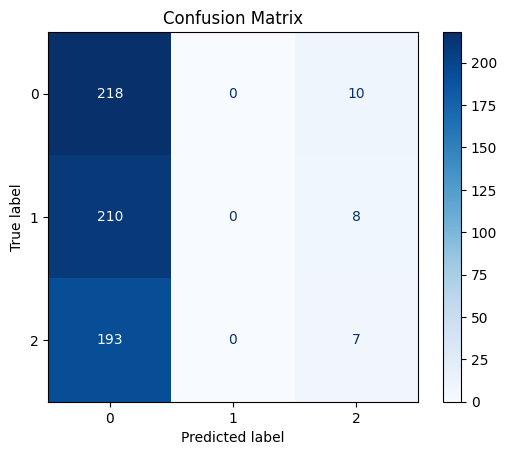

In [ ]:


# Assuming `features` are the extracted features for train_images
# and `train_labels` and `test_labels` are the corresponding labels for train and test sets.

# Generate dummy labels for demonstration (replace with actual labels)
train_labels = np.random.randint(0, 3, size=len(train_images_flat))  # Replace with actual labels
test_labels = np.random.randint(0, 3, size=len(test_images))  # Replace with actual labels

# Train SVM model
svm_model = SVC(kernel='rbf', C=10, gamma=0.1, random_state=42)
svm_model.fit(features, train_labels)

# Extract features for test images
test_images_flat = test_images.reshape(test_images.shape[0], -1)
test_features = elm.transform(test_images_flat)

# Predict on test set
predictions = svm_model.predict(test_features)

# Evaluate accuracy
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy on test set:", accuracy)

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(train_labels))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [60]:

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
val_gen = datagen.flow_from_directory(
    path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(train_gen.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_gen, validation_data=val_gen, epochs=10)




Found 17549 images belonging to 15 classes.
Found 3089 images belonging to 15 classes.
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


549/549 ━━━━━━━━━━━━━━━━━━━━ 59s 104ms/step - accuracy: 0.6251 - loss: 1.2159 - val_accuracy: 0.8064 - val_loss: 0.5887
Epoch 2/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 56s 102ms/step - accuracy: 0.8279 - loss: 0.5121 - val_accuracy: 0.8381 - val_loss: 0.4949
Epoch 3/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 54s 99ms/step - accuracy: 0.8559 - loss: 0.4386 - val_accuracy: 0.8521 - val_loss: 0.4386
Epoch 4/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 54s 98ms/step - accuracy: 0.8718 - loss: 0.3967 - val_accuracy: 0.8644 - val_loss: 0.4105
Epoch 5/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 91s 166ms/step - accuracy: 0.8744 - loss: 0.3757 - val_accuracy: 0.8657 - val_loss: 0.3995
Epoch 6/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 77s 139ms/step - accuracy: 0.8760 - loss: 0.3701 - val_accuracy: 0.8657 - val_loss: 0.3918
Epoch 7/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 77s 140ms/step - accuracy: 0.8856 - loss: 0.3352 - val_accuracy: 0.8637 - val_loss: 0.3881
Epoch 8/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 77s 141ms/step - accuracy: 0.8852 - loss: 0.3363 - val_a

In [ ]:
# Extract features for test images
test_images_flat = test_images.reshape(test_images.shape[0], -1)
test_features = elm.transform(test_images_flat)

# Predict on test set
predictions = model.predict(test_features)

# Evaluate accuracy
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy on test set:", accuracy)

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(train_labels))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()